In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import numpy as np
import sys
import pandas as pd
import os
sys.path.append("../")
import utils.common
import seaborn as sns
import matplotlib.pyplot as plt
import utils.exp_pong_multi_ball
from utils.common import get_trial_paths, get_trial_df, get_initial_state_df, get_prey_pos_df, display_prey_agent_pos, get_agent_pos_df, get_occluders_pos_df

In [113]:
human_base_path = '../../logs/exp_pong_multi_ball/0'
trial_paths = get_trial_paths(human_base_path)
trial_df = get_trial_df(trial_paths)
trial_df = (trial_df.pipe(get_initial_state_df)
    .pipe(utils.exp_pong_multi_ball.get_condition_df)
    # .drop('initial_state', axis='columns')
    .pipe(get_agent_pos_df)
    .pipe(get_occluders_pos_df)  
    .pipe(utils.common.get_states_df)
    .assign(prey_pos=utils.common.get_prey_pos_from_states)
    # finding sorted indices of prey according to y position
    .assign(prey_ix=lambda df: [np.argsort(prey_y) for prey_y in df.prey_y], axis=1)
    # sorting x coordinates 
    .assign(prey_x=lambda df: [np.array(prey_x)[prey_ix] for (prey_x, prey_ix) in zip(df.prey_x, df.prey_ix)]) 
    # sorting y coordinates       
    .assign(prey_y=lambda df: [np.array(prey_y)[prey_ix] for (prey_y, prey_ix) in zip(df.prey_y, df.prey_ix)])   
    # sorting position
    .assign(prey_pos=lambda df: [np.array(prey_pos)[prey_ix] for (prey_pos, prey_ix) in zip(df.prey_pos, df.prey_ix)])
    .assign(prey_end_step=utils.exp_pong_multi_ball.get_prey_end_step, 
        error=utils.exp_pong_multi_ball.get_error,
        success=utils.exp_pong_multi_ball.get_success,
        prey_visible=utils.exp_pong_multi_ball.get_prey_visible,
        prey_visible_step=utils.exp_pong_multi_ball.get_prey_visible_step)
    .drop(['states'], axis='columns'))
# creating separate columns for succes/error/y-pos/x-pos of each prey. 
# TODO: Change so that 2 is not hardcoded. 
trial_df = (trial_df
    .merge(pd.DataFrame(trial_df.prey_x.to_list(), columns=['prey_x_%i' % i for i in range(2)], index=trial_df.index), left_index=True, right_index=True)
    .merge(pd.DataFrame(trial_df.prey_y.to_list(), columns=['prey_y_%i' % i for i in range(2)], index=trial_df.index), left_index=True, right_index=True)
    .merge(pd.DataFrame(trial_df.error.to_list(), columns=['error_%i' % i for i in range(2)], index=trial_df.index), left_index=True, right_index=True)
    .merge(pd.DataFrame(trial_df.success.to_list(), columns=['success_%i' % i for i in range(2)], index=trial_df.index), left_index=True, right_index=True)
    .merge(pd.DataFrame(trial_df.prey_pos.to_list(), columns=['prey_pos_%i' % i for i in range(2)], index=trial_df.index), left_index=True, right_index=True)
    .merge(pd.DataFrame(trial_df.prey_visible_step.to_list(), columns=['prey_visible_step_%i' % i for i in range(2)], index=trial_df.index), left_index=True, right_index=True)
    .set_index(['prey_x_0', 'prey_x_1', 'prey_y_0', 'prey_y_1', 'occluded'])
    .sort_index()
)

<ipython-input-113-0753e7257386>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  .assign(prey_pos=lambda df: [np.array(prey_pos)[prey_ix] for (prey_pos, prey_ix) in zip(df.prey_pos, df.prey_ix)])


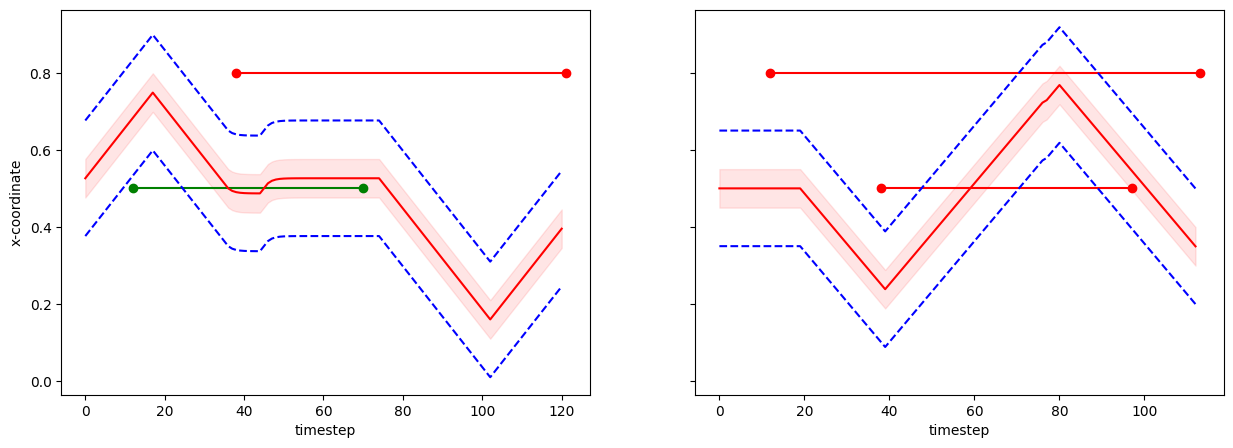

In [114]:
n_conditions = 2
conditions = np.random.choice(trial_df.loc[pd.IndexSlice[:, :, :, :, True], :].index.unique(), n_conditions, replace=False)
f, axs = plt.subplots(1, n_conditions, figsize=(15, 5), dpi=100, sharey=True)
for i_c, condition in enumerate(conditions):
    trials = trial_df.loc[condition].iloc[0]
    agent_pos = trials.agent_pos
    occluders_pos = trials.occluders_pos
    prey_pos = trials.prey_pos
    prey_visible_step = trials.prey_visible_step
    n_trials = len(trials)
    success = trials.success
    for (pvs, p, s)in zip(prey_visible_step, prey_pos, success):
        p = np.array(p)
        t_start = np.where(p[:, 1] <= 1.0)[0][0]
        t_end = len(p)
        t = np.arange(t_start, t_end)
        # axs[i_c].axvline(pvs)
        color = 'green' if s else 'red'
        axs[i_c].plot([t_start, t_end], [p[t_start, 0], p[t_end-1, 0]], 'o-', color=color)
        # axs[i_c].scatter(t, p[t_start:t_end, 0], label=p[0,1], c=np.linspace(0,1, num=len(t)), marker='_', cmap=cmap)                
    axs[i_c].plot(np.arange(len(agent_pos[:, 0])), occluders_pos[:, 0], color='blue', linestyle='--')
    axs[i_c].plot(np.arange(len(agent_pos[:, 0])), occluders_pos[:, 1], color='blue', linestyle='--')
    axs[i_c].fill_between(np.arange(len(agent_pos[:, 0])), agent_pos[:, 0]-0.05, agent_pos[:, 0]+0.05, color='red', alpha=0.1)
    axs[i_c].plot(np.arange(len(agent_pos)), agent_pos[:, 0], c='red')
    axs[i_c].set_xlabel('timestep')
axs[0].set_ylabel('x-coordinate')
plt.show()

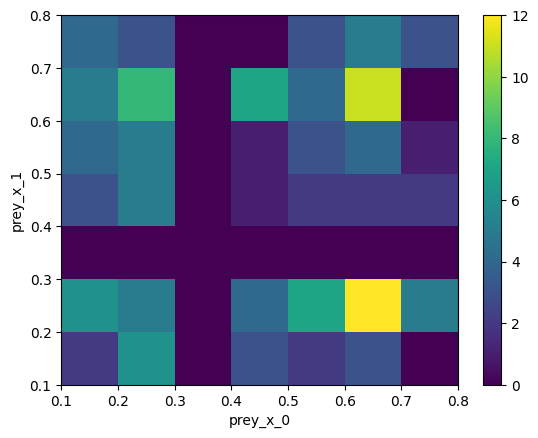

In [117]:
im = plt.hist2d(x=trial_df.reset_index().prey_x_0, y=trial_df.reset_index().prey_x_1, bins=np.linspace(0.1, 0.8, 8))
plt.xlabel('prey_x_0')
plt.ylabel('prey_x_1')
plt.colorbar()
plt.show()

In [144]:
conditions = np.unique(np.asarray(trial_df.reset_index()[['prey_x_0', 'prey_x_1']].to_records(index=False)))
np.where(np.asarray(trial_df.iloc[100].prey_pos_0)[:, 1] <= (0.1 + 0.05))

(array([69]),)